# [Distributed Linear Regression with cuML](https://medium.com/dropout-analytics/distributed-linear-regression-with-cuml-b4f32d727e22?source=friends_link&sk=458531bdbb4cf88060d06736f2d4c646)

In this Notebook we're going to build a distributed cuML `LinearRegression` model. 

Start by identifying your `client`, which is how BlazingSQL and cuML connect to all available GPUs and distribute.

In [ ]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)

## ETL - Data Prep

With `client` out of the way, let's grab our data. 

Initialize a distributed BlazingContext instance, and create a table from a sample of the NYC Taxi dataset stored in a public AWS S3 bucket.

In [ ]:
from blazingsql import BlazingContext

# initilize BlazingContext distributed 
bc = BlazingContext(dask_client=client, network_interface='lo')

In [ ]:
# register AWS S3 bucket 
bc.s3('blazingsql-colab', bucket_name='blazingsql-colab')

# create table from parquet file in that S3 bucket
bc.create_table('taxi', 's3://blazingsql-colab/yellow_taxi/1_0_0.parquet')

Our model will take three X variables (`passenger_count`, `trip_distance`, `tolls`) and, based on those values, try to predict the `fare_amount` (y) of any given ride. 

Let's query (`.sql()`) for all of these, and keep the dask_cudf.DataFrame of the results as a variable df to see what it's about.

In [ ]:
query = '''
        select
            passenger_count,
            trip_distance,
            Tolls_amount as tolls,
            Fare_amount as fare_amount
        from 
            taxi
            '''

df = bc.sql(query)

# queries return as dask_cudf.DataFrame
type(df)

In [ ]:
df

cuML expects y values to be float64 dtype, we can easily convert `fare_amount` (currently float32 dtype) to match that with `.astype()`, and then call `.tail()`  -- _which, like .compute() and .head(), converts the dask_cudf.DataFrame to a cudf.DataFrame_ --  to display some data.

In [ ]:
# adjust fare_amount to be expected dtype
df.fare_amount = df.fare_amount.astype('float64')

# calling .compute(), .head() or .tail() converts to cudf.DataFrame
df.tail()

To conclude the ETL process, noting that we have 18.8M rows to work with, let's split the data into training and testing datasets by taking the first 15,000,000 rows as `train_data` and the last 3,000,000 rows as `test_data`.

In [ ]:
# crude train / test split
bc.create_table('train_data', df.head(15000000))

bc.create_table('test_data', df.tail(3000000))

## Distributed Linear Regression

It's time to build our model! Start by importing `LinearRegression` from cuml.dask's `linear_model`, and pass in client upon initialization to link the model with our GPU cluster.

In [ ]:
from cuml.dask.linear_model import LinearRegression

lr = LinearRegression(client=client)

`.fit()` the model with training data so it can learn how our X and y values interact.

In [ ]:
# training X & y values
X_train = bc.sql('SELECT passenger_count, trip_distance, tolls FROM train_data')
y_train = bc.sql('SELECT fare_amount FROM train_data').fare_amount

In [ ]:
lr.fit(X_train, y_train)

Then `.predict()` the `fare_amount` of the taxi rides in our test dataset. Predictions are returned as a dask_cudf.Series.

In [ ]:
# testing X & y values
X_test = bc.sql('SELECT passenger_count, trip_distance, tolls FROM test_data')
y_test = bc.sql('SELECT fare_amount FROM test_data').fare_amount

preds = lr.predict(X_test)

# predictions return as dask_cudf.Series
type(preds)

## Results

Let's make a quick dataframe to compare the first 10 actual fares with the first 10 predicted fares side by side.

In [ ]:
r_df = bc.sql('SELECT fare_amount AS actual FROM test_data LIMIT 10')

r_df = r_df.compute()

r_df['predicted'] = preds.head(10)

r_df

Those are pretty close! Let's scatter the first 100 actual and predicted values to get a better picture.

In [ ]:
r_df = bc.sql('SELECT fare_amount AS actual FROM test_data LIMIT 100')

r_df = r_df.compute()

r_df['predicted'] = preds.head(100)

r_df.to_pandas().plot(kind='scatter', x='actual', y='predicted')

Looks like we're almost on the money, with some outliers throwing us off past $40.

We can `.compute().to_pandas()` and score the model with sklearn's r2_score() to find out.

In [ ]:
from sklearn.metrics import r2_score

# convert to pandas.DataFrame for sklearn r2 score
actual = y_test.compute().to_pandas()
predicted = preds.compute().to_pandas()

r2_score(y_true=actual, y_pred=predicted)

## Try for yourself

You can run this demo (no set up required) by cloning the [Notebook's gist](https://gist.github.com/gumdropsteve/ceab0ffdcfef63317747d33501137108) into a BlazingSQL Notebooks environment with this command in Terminal:

```bash
git clone https://gist.github.com/gumdropsteve/ceab0ffdcfef63317747d33501137108 distributed_lr_story
```

[![image.png](https://miro.medium.com/max/1400/0*KYxjArF5xE2957G-)](https://bit.ly/bsql-notebooks)
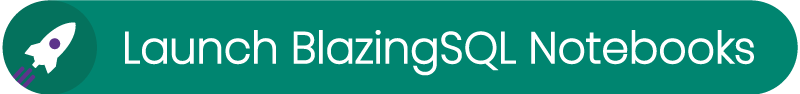